# Simple MNIST NN from scratch

> Simple MNIST NN from scratch


- skip_showdoc: true
- skip_exec: true


In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Here's a video I made explaining all the math and showing my progress as I coded the network: https://youtu.be/w8yWXqWQYmU

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import datasets
from tqdm.notebook import tqdm

In [ ]:
# Import dependencies
import torch 
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Get data 
train = datasets.MNIST(root="data", download=True, train=True)

In [ ]:
m_data = train.data.reshape(60000, 28*28)

In [ ]:
np_data = np.array(m_data)
target = np.array(train.targets)

In [ ]:
data = np.insert(np_data, 0, target, axis=1)

In [ ]:
np_data.shape, target.shape, data.shape

((60000, 784), (60000,), (60000, 785))

In [ ]:
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

In [ ]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [ ]:
Y_train

array([0, 7, 6, ..., 6, 5, 3], dtype=uint8)

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [ ]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in tqdm(range(iterations)):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 50 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.20, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration:  0
[0 9 0 ... 0 0 5] [0 7 6 ... 6 5 3]
0.1644406779661017
Iteration:  50
[0 7 6 ... 6 0 8] [0 7 6 ... 6 5 3]
0.6483898305084745
Iteration:  100
[0 7 6 ... 6 5 7] [0 7 6 ... 6 5 3]
0.7637118644067796
Iteration:  150
[0 7 6 ... 6 5 7] [0 7 6 ... 6 5 3]
0.810322033898305
Iteration:  200
[0 7 6 ... 6 5 7] [0 7 6 ... 6 5 3]
0.8343559322033899
Iteration:  250
[0 7 6 ... 6 5 7] [0 7 6 ... 6 5 3]
0.8489322033898306
Iteration:  300
[0 7 6 ... 6 5 7] [0 7 6 ... 6 5 3]
0.8593050847457627
Iteration:  350
[0 7 6 ... 6 5 7] [0 7 6 ... 6 5 3]
0.8668135593220339
Iteration:  400
[0 7 6 ... 6 5 7] [0 7 6 ... 6 5 3]
0.8729491525423729
Iteration:  450
[0 7 6 ... 6 5 7] [0 7 6 ... 6 5 3]
0.8777457627118644


~85% accuracy on training set.

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [0]
Label:  0


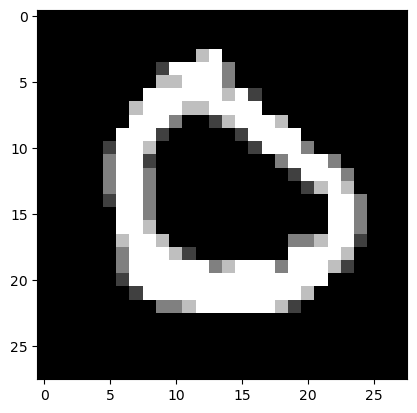

Prediction:  [7]
Label:  7


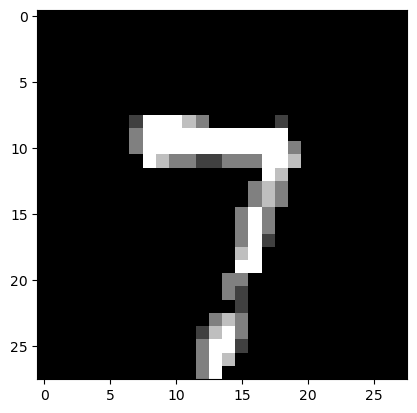

Prediction:  [6]
Label:  6


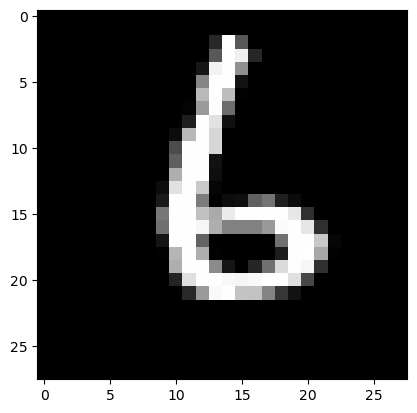

Prediction:  [7]
Label:  7


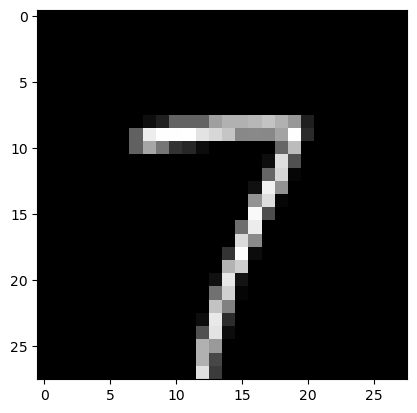

In [ ]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [ ]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[1 0 1 9 9 0 3 4 5 3 8 0 3 9 1 4 6 7 0 3 7 5 2 1 0 0 2 5 7 0 9 2 5 0 2 8 8
 5 2 3 2 3 6 5 6 5 6 5 1 7 1 7 5 7 4 9 7 7 1 3 2 5 9 9 6 4 1 6 7 7 1 5 1 6
 2 5 0 9 7 2 5 3 4 0 7 7 5 0 7 9 6 4 5 3 1 9 0 2 1 2 0 2 5 5 4 1 8 9 1 5 2
 5 3 4 2 0 2 5 0 0 4 0 3 0 7 0 0 8 4 1 7 6 3 5 0 4 6 6 1 3 8 9 1 5 6 6 1 7
 6 2 5 8 9 7 6 9 0 7 6 4 7 1 2 9 9 4 2 0 7 1 4 5 8 0 7 9 2 0 4 6 6 4 2 7 7
 0 4 7 0 9 4 6 7 6 2 4 5 1 8 1 3 2 0 4 4 7 1 2 8 2 2 3 3 7 7 9 5 1 6 1 0 7
 4 0 6 0 6 1 9 8 7 0 5 4 7 7 5 0 2 6 6 1 7 8 2 9 7 3 5 1 6 2 8 1 0 4 7 6 8
 6 6 0 7 7 7 0 0 9 6 0 8 6 6 8 6 6 8 8 0 8 7 1 8 4 5 8 2 2 5 0 1 9 0 7 3 0
 3 9 2 0 6 9 8 9 5 7 7 5 2 7 7 9 3 3 6 8 3 8 5 3 9 1 8 0 4 5 9 9 6 2 1 4 4
 0 0 9 9 1 6 3 1 7 3 7 4 6 2 9 1 0 3 2 1 1 4 8 1 2 8 4 8 7 6 4 1 3 7 7 0 3
 0 6 2 6 6 5 2 9 2 7 8 8 0 0 0 7 0 1 2 2 4 0 4 1 5 4 8 0 8 8 8 8 4 5 4 1 9
 6 5 6 4 3 8 1 3 6 9 6 7 9 9 6 3 5 1 5 1 4 1 1 9 4 0 6 4 3 8 7 9 5 1 7 0 7
 7 2 3 5 7 8 8 4 7 6 8 1 4 7 8 9 4 3 6 0 4 5 7 4 4 5 8 4 6 5 8 3 1 2 5 5 5
 6 1 9 7 6 0 3 7 4 1 8 2 

0.856

Still 84% accuracy, so our model generalized from the training data pretty well.